In [29]:
# Defining dependencies
import pandas as pd
import numpy as np
import math
import requests
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append('../ift6758/data/')
from question_2_m2 import *

In [30]:
# Loading csv into a dataframe which contains regular season game data starting season 20152016 thru 20192020
df = tidy_df_loop()
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [31]:
# Imputing empty net data in existing dataframe

df['empty_net'] = df['empty_net'].replace(np.nan,0)
df['empty_net'] = df['empty_net'].replace(True,1)
df['empty_net'] = df['empty_net'].replace(False,0)

In [32]:
# Shot angle (in degrees) added to the dataframe

list_angle = []
for i in range(0,df.shape[0]):

    if df.attacking_team_side[i] == "right":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
            
    elif df.attacking_team_side[i] == "left":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
df['angle_from_net'] = list_angle

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408783 entries, 0 to 408782
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   game_id                       408783 non-null  int64  
 1   season                        408783 non-null  int64  
 2   season_type                   408783 non-null  object 
 3   event_id                      408783 non-null  int64  
 4   home_team                     408783 non-null  object 
 5   away_team                     408783 non-null  object 
 6   home_team_side_1st_period     399561 non-null  object 
 7   attacking_team                408783 non-null  object 
 8   attacking_player              408783 non-null  object 
 9   goalie                        406884 non-null  object 
 10  period                        408783 non-null  int64  
 11  period_time                   408783 non-null  object 
 12  goal_ind                      408783 non-nul

In [34]:
# Dropping the rows that doesn't have X or Y coordinates

df = df[~df['distance_from_net'].isnull()] # distance was null for 17 rows
df = df[~df['angle_from_net'].isnull()] # angle was null for 18 rows

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408762 entries, 0 to 408782
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   game_id                       408762 non-null  int64  
 1   season                        408762 non-null  int64  
 2   season_type                   408762 non-null  object 
 3   event_id                      408762 non-null  int64  
 4   home_team                     408762 non-null  object 
 5   away_team                     408762 non-null  object 
 6   home_team_side_1st_period     399540 non-null  object 
 7   attacking_team                408762 non-null  object 
 8   attacking_player              408762 non-null  object 
 9   goalie                        406864 non-null  object 
 10  period                        408762 non-null  int64  
 11  period_time                   408762 non-null  object 
 12  goal_ind                      408762 non-nul

In [36]:
# Training (train+validation sets for model) and test sets creation

df_train = df[df['season'] != 20192020]
df_test = df[df['season'] == 20192020]

In [37]:
# mid_df.csv creation which is an input for Q3 and Q4

df.to_csv('mid_df.csv',index=False)

In [38]:
# test_df.csv creation which is an input for Q7

df_test.to_csv('test_df.csv',index=False)

In [39]:
# df_train_nogoals is a dataframe which has only no goal observations
df_train_nogoals = df_train[df_train['shot_ind']==1]

# df_train_goals is a dataframe which has only goal observations
df_train_goals = df_train[df_train['goal_ind']==1]

<Figure size 432x288 with 0 Axes>

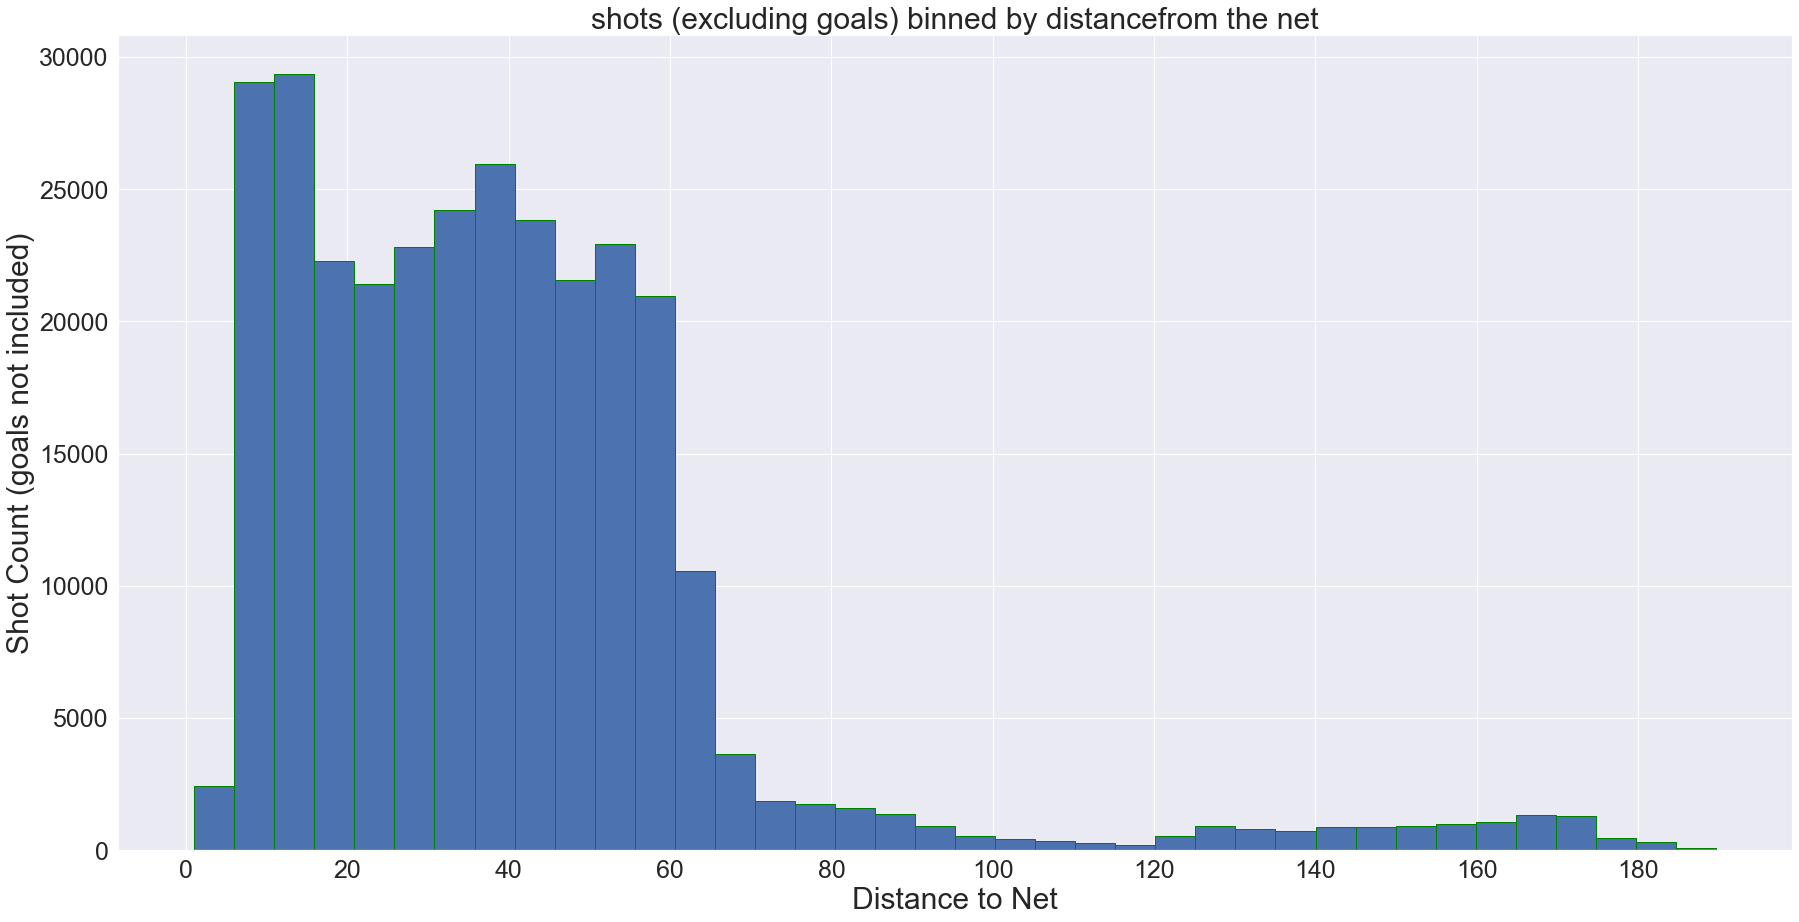

In [40]:
# Histogram of shot counts - No-goal shots binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
values = np.arange(0,df_train_nogoals['distance_from_net'].max()+5,20)
plt.hist(df_train_nogoals['distance_from_net'], edgecolor="green", bins=math.ceil((df_train_nogoals['distance_from_net'].max() - df_train_nogoals['distance_from_net'].min())/5))
plt.title("shots (excluding goals) binned by distancefrom the net",size=30)
plt.xlabel("Distance to Net",size=30)
plt.ylabel("Shot Count (goals not included)",size=30)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_1.png')

<Figure size 432x288 with 0 Axes>

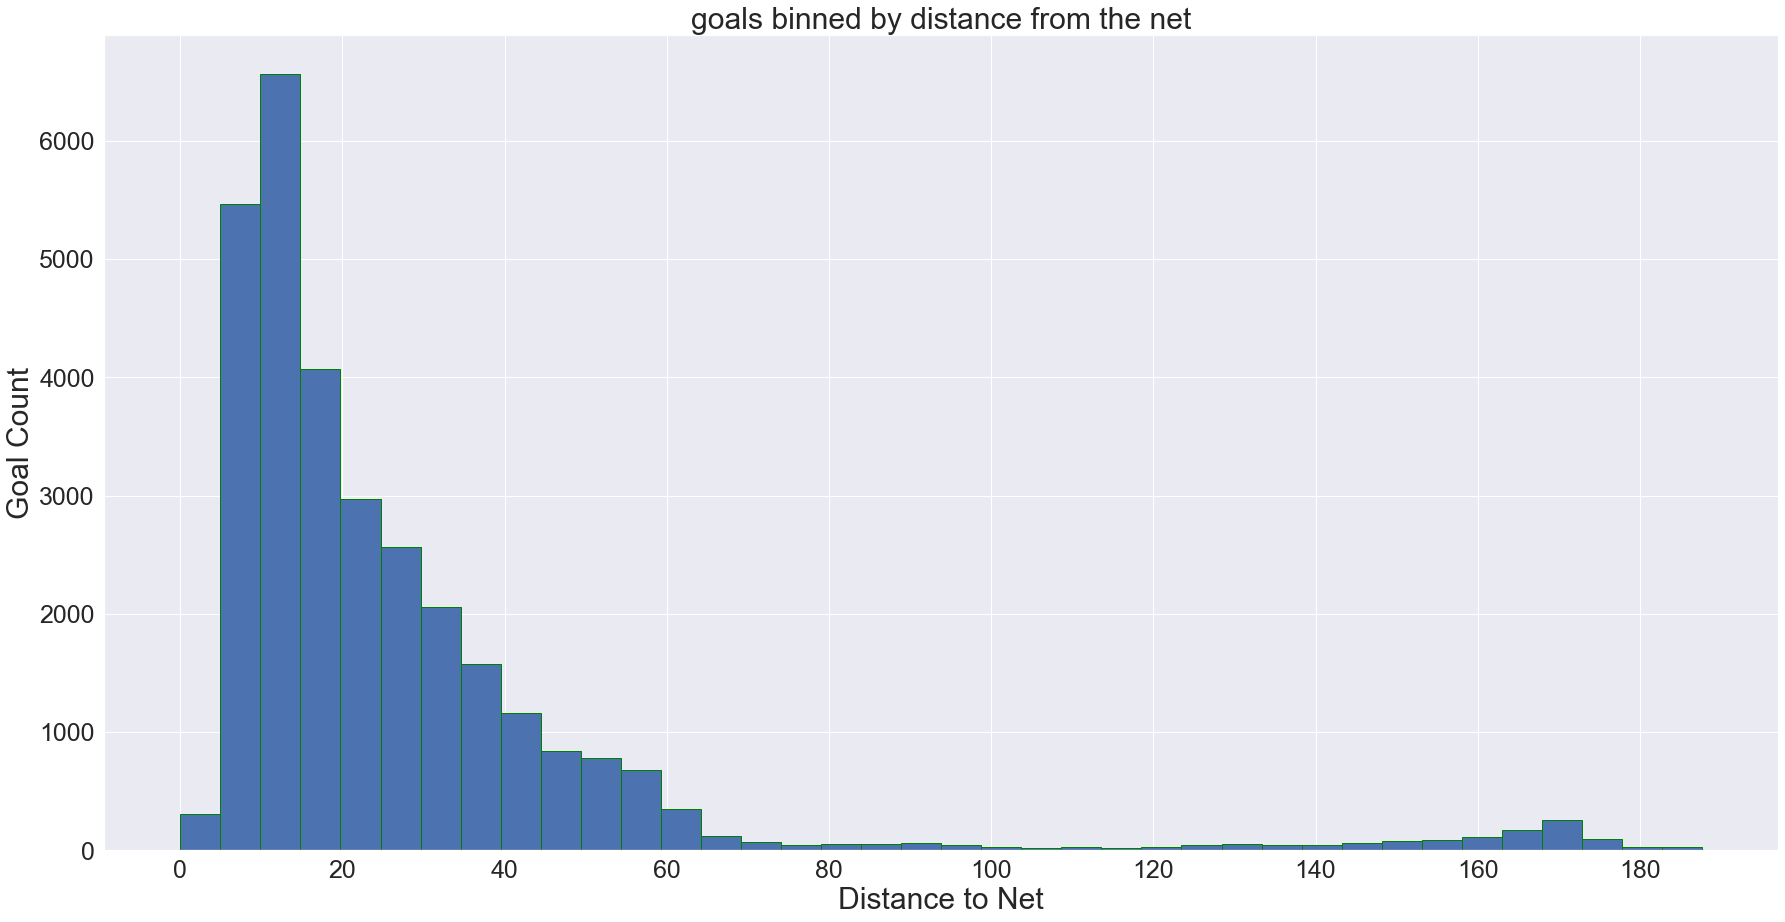

In [41]:
# Histogram of shot counts - goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
values = np.arange(0,df_train_goals['distance_from_net'].max()+5,20)
plt.hist(df_train_goals['distance_from_net'], edgecolor="green", bins=math.ceil((df_train_goals['distance_from_net'].max() - df_train_goals['distance_from_net'].min())/5))
plt.title("goals binned by distance from the net",size=30)
plt.xlabel("Distance to Net",size=30)
plt.ylabel("Goal Count",size=30)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_2.png')

<Figure size 432x288 with 0 Axes>

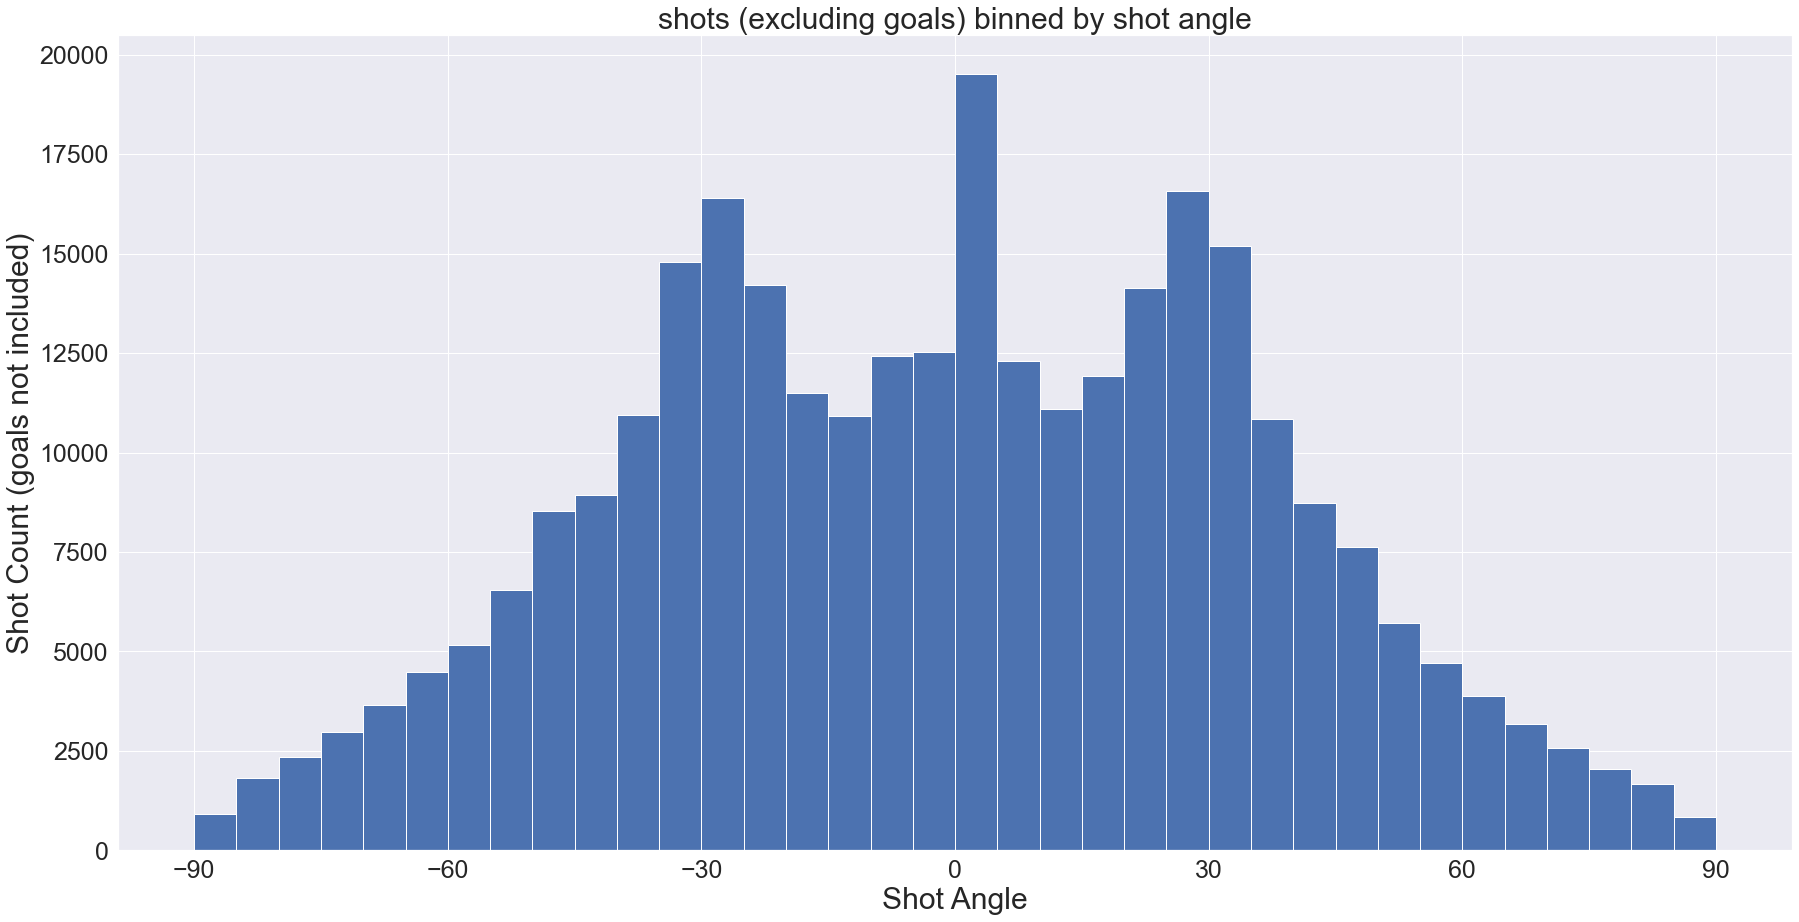

In [42]:
# Histogram of shot counts - No-goal shots binned by angle
fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_train_nogoals['angle_from_net'], bins=math.ceil((df_train_nogoals['angle_from_net'].max() - df_train_nogoals['angle_from_net'].min())/5))
plt.title("shots (excluding goals) binned by shot angle",size=30)
plt.xlabel("Shot Angle",size=30)
plt.ylabel("Shot Count (goals not included)",size=30)
plt.xticks(np.arange(-90,100,30),size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_3.png')

<Figure size 432x288 with 0 Axes>

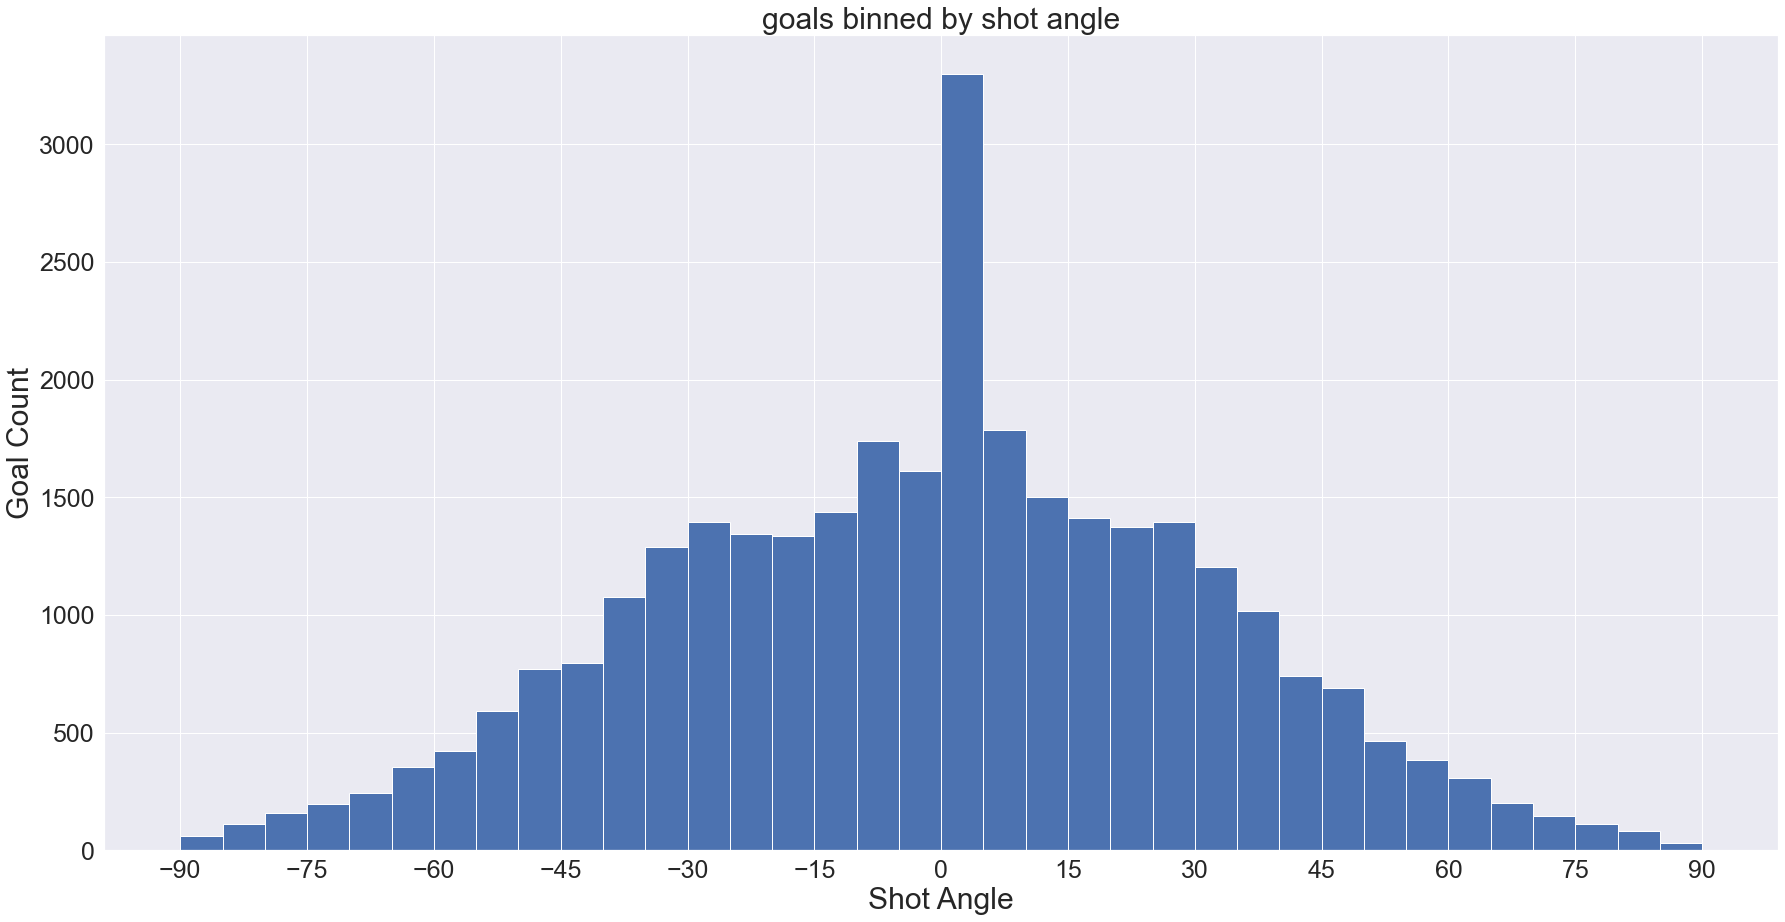

In [43]:
# Histogram of shot counts - goals binned by angle
fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_train_goals['angle_from_net'], bins=math.ceil((df_train_goals['angle_from_net'].max() - df_train_goals['angle_from_net'].min())/5))
plt.title("goals binned by shot angle",size=30)
plt.xlabel("Shot Angle",size=30)
plt.ylabel("Goal Count",size=30)
plt.xticks(np.arange(-90,100,15),size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_4.png')

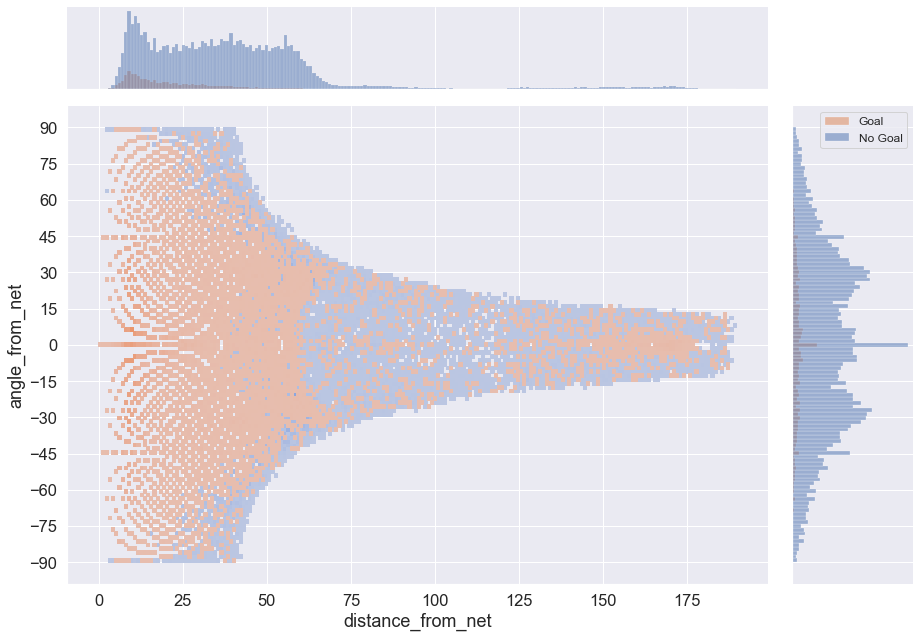

In [44]:
# Joint plot showing the relation between distance of the shot and angle of the shot
sns.set(font_scale = 1.5)
g = sns.jointplot(data=df_train, x="distance_from_net", y="angle_from_net", hue="goal_ind",legend=False, kind = "hist")
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
plt.legend(labels=["Goal","No Goal"], fontsize = 12)
plt.yticks(np.arange(-90,100,15),size = 25)
values = np.arange(0,df_train['distance_from_net'].max()+5,20)
plt.xticks(values,size = 25)
plt.show(g)
g.savefig("Joint_Plot.png")

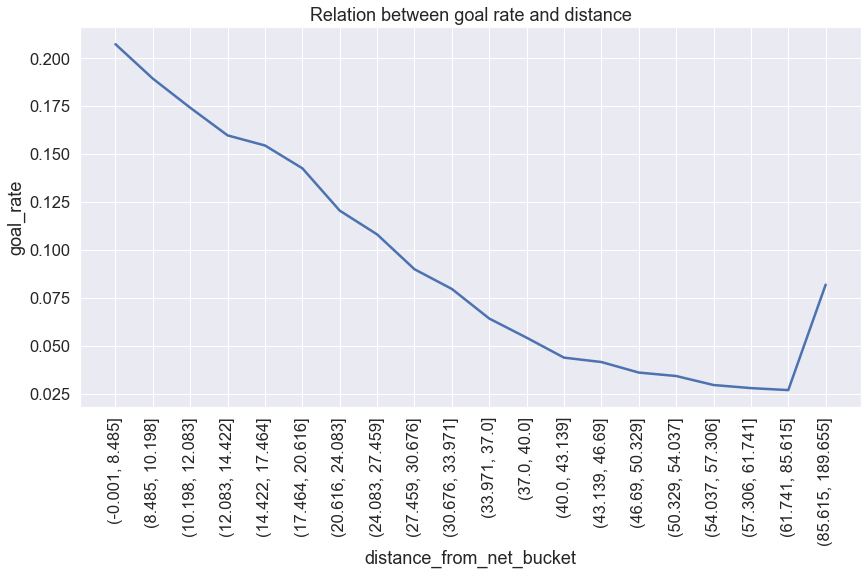

In [45]:
# Relation between goal rate and distance

df_train1 = df_train.copy()

n_buckets = 20

df_train1['distance_from_net_bucket'] = pd.qcut(df_train1['distance_from_net'], n_buckets, labels = False) +1
df_train1['angle_from_net_bucket'] = pd.qcut(df_train1['angle_from_net'], n_buckets, labels = False) +1

intervals = list(set(pd.qcut(df_train1['distance_from_net'], n_buckets)))
intervals.sort()
intervals = [str(interval) for interval in intervals]


intervals_ang = list(set(pd.qcut(df_train1['angle_from_net'], n_buckets)))
intervals_ang.sort()
intervals_ang = [str(interval_ang) for interval_ang in intervals_ang]

df_train1['shot_count'] = 1
df_train_copy = df_train1.copy()


df_train_copy1 = df_train_copy[['goal_ind','shot_count','distance_from_net_bucket']].groupby(['distance_from_net_bucket']).sum().reset_index()
df_train_copy1['goal_rate'] = df_train_copy1['goal_ind']/df_train_copy1['shot_count']

y1_max = max(df_train_copy1['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'distance_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy1, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals, rotation = 90)
ax.set_ylim(bottom=0, top=y1_max * 1.1)
plt.title(f"Relation between goal rate and distance")
plt.autoscale()
fig.savefig("Q2_5.png", bbox_inches = 'tight')


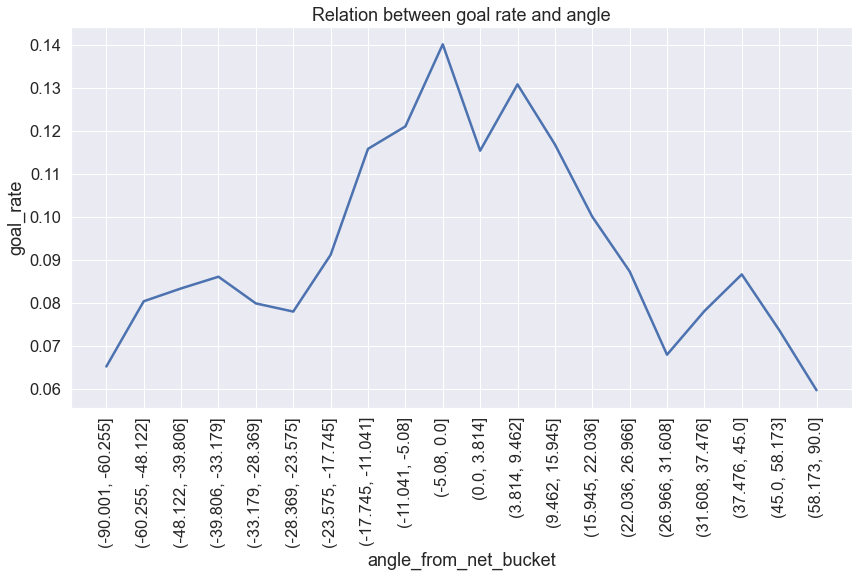

In [46]:
# Relation between goal rate and angle

df_train_copy2 = df_train_copy[['goal_ind','shot_count','angle_from_net_bucket']].groupby(['angle_from_net_bucket']).sum().reset_index()
df_train_copy2['goal_rate'] = df_train_copy2['goal_ind']/df_train_copy2['shot_count']

y2_max = max(df_train_copy2['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'angle_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy2, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals_ang, rotation = 90)
ax.set_ylim(bottom=0, top=y2_max * 1.1)
plt.title(f"Relation between goal rate and angle")
plt.autoscale()
fig.savefig("Q2_6.png", bbox_inches = 'tight')


In [47]:
#goals only to be binned by distance for empty net and non-empty net events

df_empty_net_goal = df_train[(df_train['empty_net']==1) & (df_train['goal_ind']==1)]
df_non_empty_net_goal = df_train[(df_train['empty_net']==0) & (df_train['goal_ind']==1)]
#print(df_empty_net_goal.shape[0], df_non_empty_net_goal.shape[0])

<Figure size 432x288 with 0 Axes>

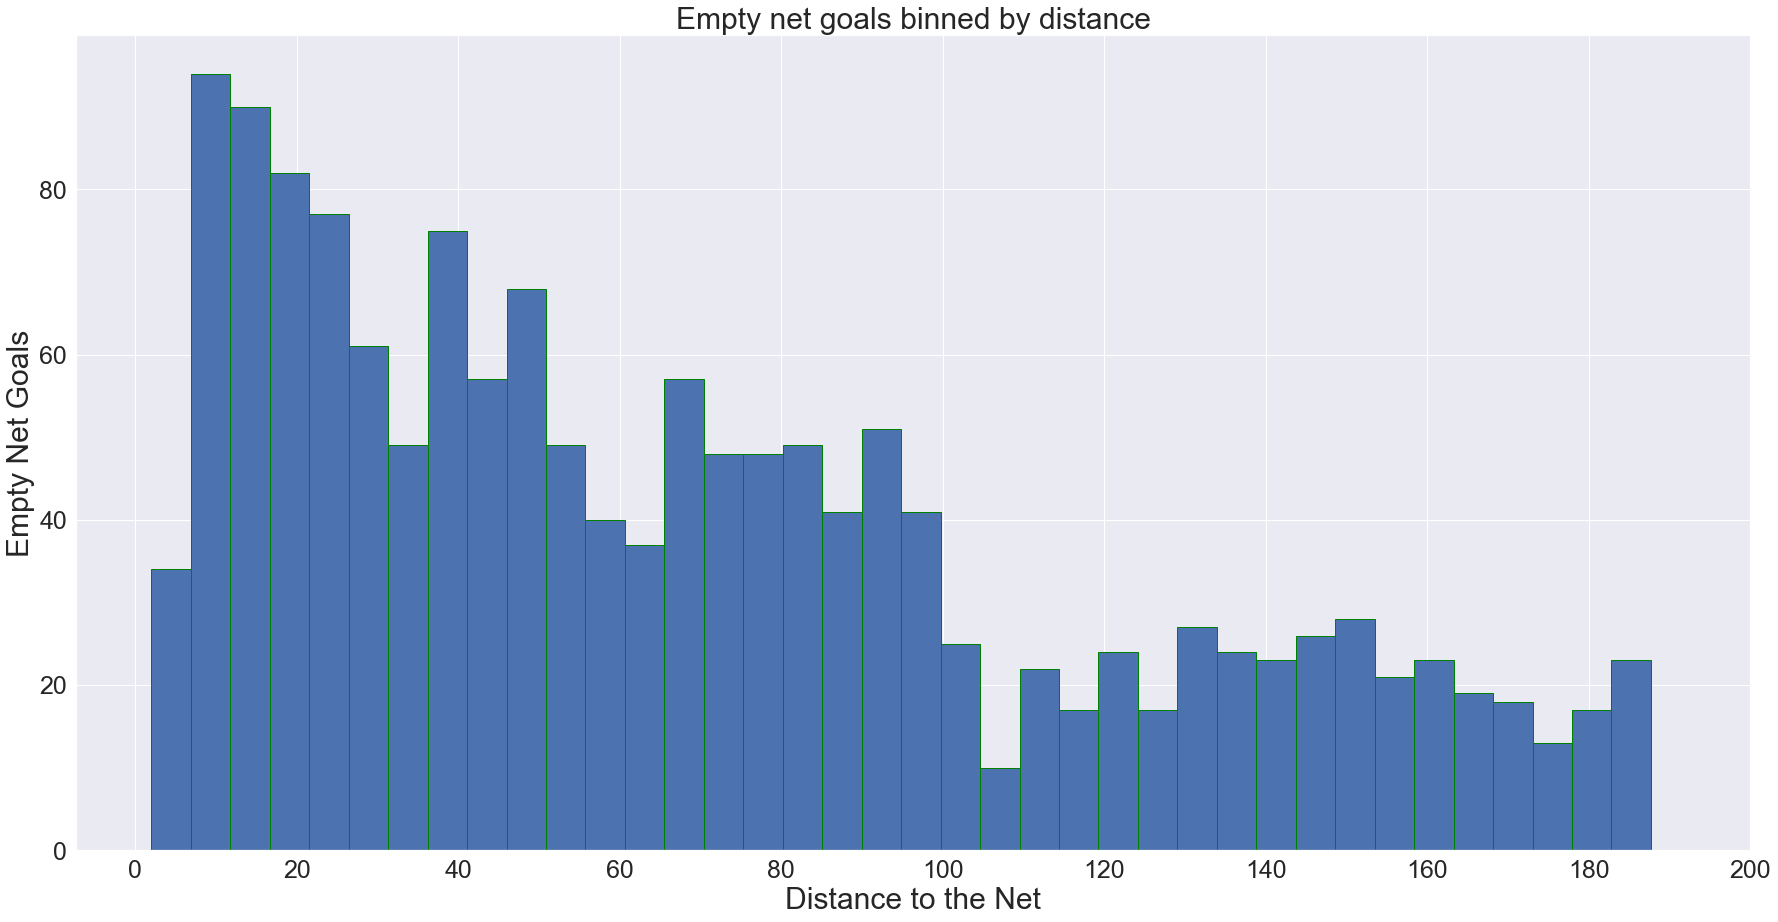

In [48]:
# Empty net goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_empty_net_goal['distance_from_net'], edgecolor="green", bins=math.ceil((df_empty_net_goal['distance_from_net'].max() - df_empty_net_goal['distance_from_net'].min())/5))
plt.title("Empty net goals binned by distance",size=30)
plt.xlabel("Distance to the Net",size=30)
plt.ylabel("Empty Net Goals",size=30)
values = np.arange(0,df_empty_net_goal['distance_from_net'].max()+20,20)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_7.png')



<Figure size 432x288 with 0 Axes>

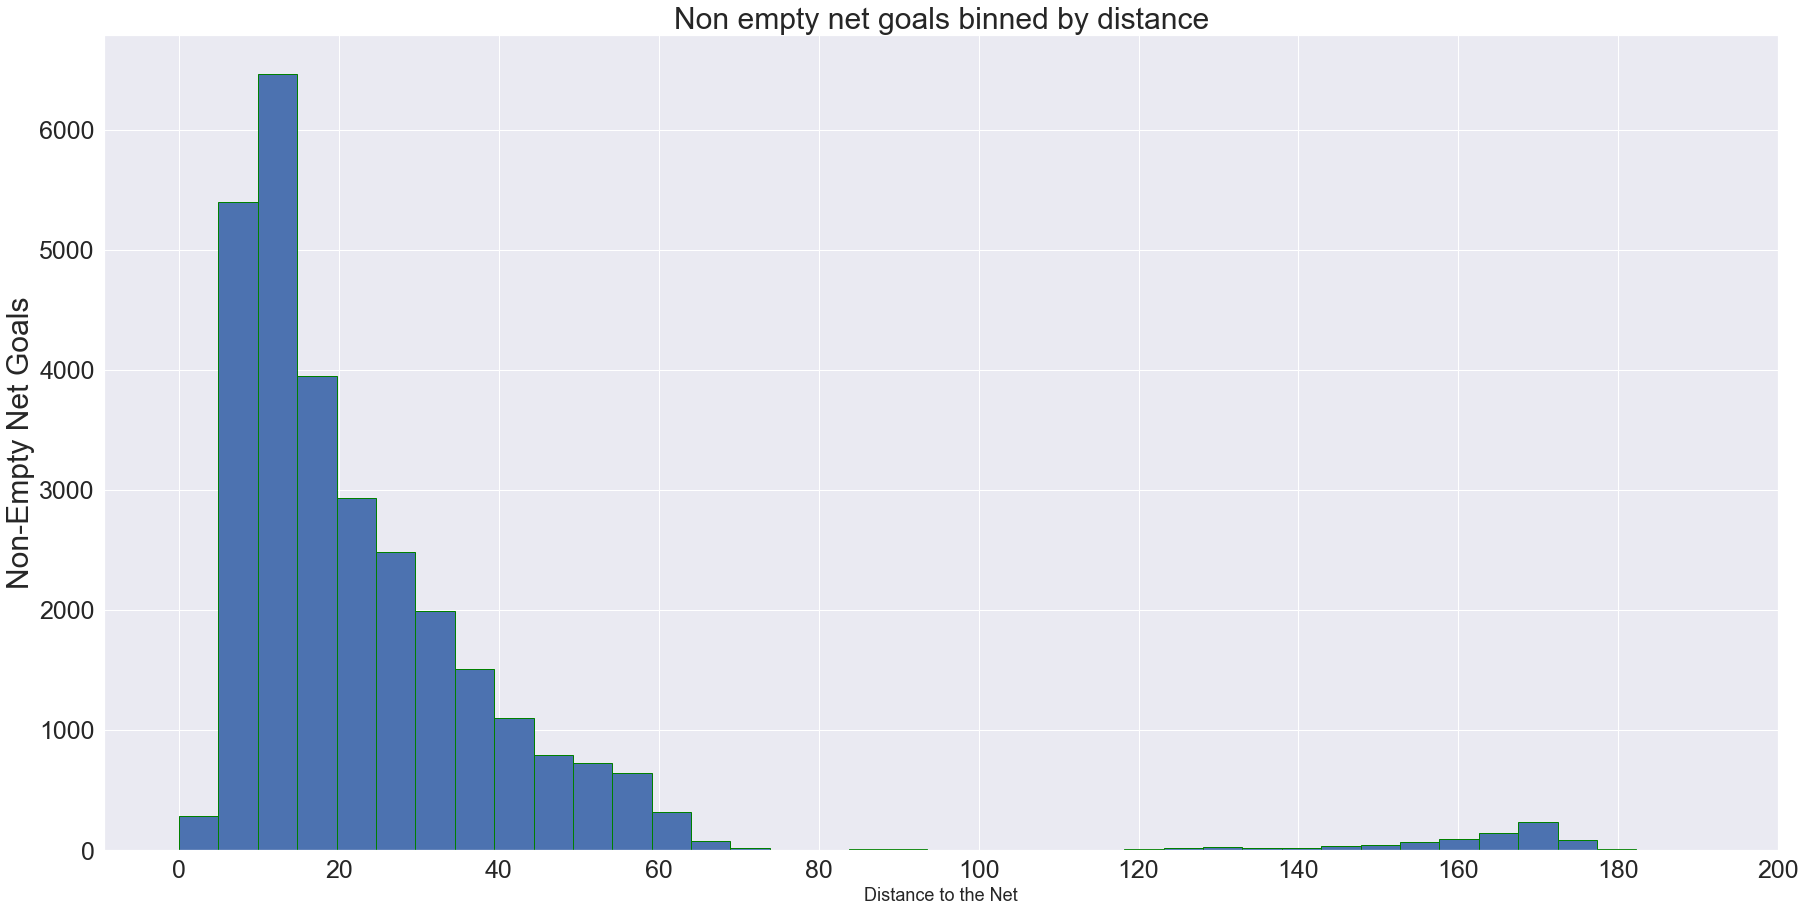

In [49]:
# Non-Empty net goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_non_empty_net_goal['distance_from_net'], edgecolor="green", bins=math.ceil((df_non_empty_net_goal['distance_from_net'].max() - df_non_empty_net_goal['distance_from_net'].min())/5))
plt.title("Non empty net goals binned by distance",size=30)
plt.xlabel("Distance to the Net")
plt.ylabel("Non-Empty Net Goals",size=30)
values = np.arange(0,df_non_empty_net_goal['distance_from_net'].max()+20,20)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_8.png')


# Events that have incorrect features (e.g. wrong x/y coordinates) validated by the NHL gamecenter video clips

When a goal is a non-empty net goal, it is very unlikely to be hit from farther distance. 
Hence, all the non-empty goals hit beyond a threshold distance (150 set in this case) and that are hit from behind the goal post (X = +/- 89) are examined againt the actual videos and determined that the coordinates of these shots in our are wrong



In [50]:
df_train_goals = df_train[df_train['goal_ind']==1]
df_goals_anomaly = df_train_goals[(df_train_goals['x_coordinates'].abs()>89)&(df_train_goals['distance_from_net']>=150)&(df_train_goals['empty_net']==0)]
df_goals_anomaly[['game_id','season','period','period_time','home_team','away_team','attacking_team','attacking_player','x_coordinates','y_coordinates','empty_net']]

,game_id,season,period,period_time,home_team,away_team,attacking_team,attacking_player,x_coordinates,y_coordinates,empty_net
4192,2015020071,20152016,2,02:27,New York Islanders,San Jose Sharks,New York Islanders,Anders Lee,97.0,7.0,0
9678,2015020163,20152016,3,19:51,Edmonton Oilers,Calgary Flames,Calgary Flames,Michael Frolik,93.0,26.0,0
15508,2015020261,20152016,3,05:38,New York Islanders,Arizona Coyotes,New York Islanders,John Tavares,-92.0,10.0,0
22723,2015020383,20152016,2,01:16,Columbus Blue Jackets,Florida Panthers,Florida Panthers,Vincent Trocheck,-92.0,-20.0,0
110213,2016020510,20162017,2,10:27,Florida Panthers,Detroit Red Wings,Florida Panthers,Derek MacKenzie,-97.0,21.0,0
